# Tutorial 4

In [70]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, kron

from matplotlib import pyplot as plt

a).

In [4]:
Id = np.array([[1,0], [0,1]])
Sx = np.array([[0,1], [1,0]])
Sz = np.array([[1,0], [0,-1]])

print(Id)
print(Sx)
print(Sz)

[[1 0]
 [0 1]]
[[0 1]
 [1 0]]
[[ 1  0]
 [ 0 -1]]


In [6]:
Id = csr_matrix(Id)
Sx = csr_matrix(Sx)
Sz = csr_matrix(Sz)

In [7]:
Id, Sx, Sz

(<2x2 sparse matrix of type '<class 'numpy.intc'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x2 sparse matrix of type '<class 'numpy.intc'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x2 sparse matrix of type '<class 'numpy.intc'>'
 	with 2 stored elements in Compressed Sparse Row format>)

b).

In [19]:
def generate_sz_j(L):

    szj_list = []
    for i in range(L):
        # prepare the matrix
        for j in range(L):
            # put Sz on j-th position for j = i
            if j == i:
                next_matrix = Sz
            # put Id elsewhere
            else:
                next_matrix = Id

            # first term
            if j == 0:
                szj_matrix = next_matrix
            # 2nd and further terms
            else:
                szj_matrix = kron(szj_matrix, next_matrix, format='csr')

        szj_list += [szj_matrix]
    
    return szj_list

In [21]:
# test the code

generate_sz_j(2)[1].toarray()

array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0, -1]], dtype=int32)

c).

In [22]:
def generate_sx_j(L):

    sxj_list = []
    for i in range(L):
        # prepare the matrix
        for j in range(L):
            # put Sx on j-th position for j = i
            if j == i:
                next_matrix = Sx
            # put Id elsewhere
            else:
                next_matrix = Id

            # first term
            if j == 0:
                sxj_matrix = next_matrix
            # 2nd and further terms
            else:
                sxj_matrix = kron(sxj_matrix, next_matrix, format='csr')

        sxj_list += [sxj_matrix]
    
    return sxj_list

In [24]:
# test the code

generate_sx_j(2)[1].toarray()

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=int32)

d).

In [26]:
def gen_hamiltonian(sx_list, sz_list, g, J):

    L = len(sz_list)
    H = np.zeros((2**L, 2**L))
    H = csr_matrix(H)

    for j in range(L):
        H += -J*sx_list[j%L]*sx_list[(j+1)%L] + -g*sz_list[j%L]

    return H

In [49]:
# test the code

L = 2
g = 0.1
J = 1
sz_list = generate_sz_j(L)
sx_list = generate_sx_j(L)
H = gen_hamiltonian(sx_list, sz_list, g, J)

H.toarray()

array([[-0.2,  0. ,  0. , -2. ],
       [ 0. ,  0. , -2. ,  0. ],
       [ 0. , -2. ,  0. ,  0. ],
       [-2. ,  0. ,  0. ,  0.2]])

e).

In [54]:
eigval, eigvec = scipy.sparse.linalg.eigsh(H, k=3)

In [55]:
eigval

array([-2.00997512,  2.        ,  2.00997512])

In [56]:
eigvec.shape

(4, 3)

In [58]:
# comparing improved Lanczos method from Scipy vs full diagonalization of Numpy for L = 12

L = 12
g = 0.1
J = 1
sz_list = generate_sz_j(L)
sx_list = generate_sx_j(L)
H = gen_hamiltonian(sx_list, sz_list, g, J)

import timeit

start = timeit.default_timer()

_, _ = scipy.sparse.linalg.eigsh(H, k=L**2-1)

stop = timeit.default_timer()

scipy_time = stop - start

print('Time for Scipy improved Lanczos method: ', scipy_time)


start = timeit.default_timer()

_, _ = np.linalg.eigh(H.toarray())

stop = timeit.default_timer()

numpy_time = stop - start

print('Time for Numpy full diagonalization: ', numpy_time)

print(f'The full diagonalization of Numpy takes {numpy_time/scipy_time}x more time vs the improved Lanczos method of Scipy.')

Time for Scipy improved Lanczos method:  1.0124264999999468
Time for Numpy full diagonalization:  10.402973799999927
The full diagonalization of Numpy takes 10.275287934482625x more time vs the improved Lanczos method of Scipy.


f).

In [74]:
g_list = np.linspace(0, 2, 20)
L_list = [6, 8, 10, 12]
dE1_list = []
dE2_list = []

psi_gs = []

for L in L_list:
    J = 1
    sz_list = generate_sz_j(L)
    sx_list = generate_sx_j(L)

    psi_gs_L = []
    dE1_L = []
    dE2_L = []

    for g in g_list:
        H = gen_hamiltonian(sx_list, sz_list, g, J)
        eigval, eigvec = scipy.sparse.linalg.eigsh(H, k=(L**2)-1)
        psi_gs_L += [eigvec[:, 0]]
        dE1_L += [eigval[1] - eigval[0]]
        dE2_L += [eigval[2] - eigval[0]]

    psi_gs += [psi_gs_L]
    dE1_list += [dE1_L]
    dE2_list += [dE2_L]

In [60]:
def LD_spin_corr(L, psi_gs):

    sxj = generate_sx_j(L)

    transformed_psi =  sxj[0]*sxj[int(L/2)]*psi_gs

    return np.inner(psi_gs, transformed_psi)

In [67]:
# test the code for L = 6 and g = 0

LD_spin_corr(6, psi_gs[0][0])

1.0000000000000004

In [68]:
C = []
L_list = [6, 8, 10, 12]
g_list = np.linspace(0, 2, 20)

for i in range(len(L_list)):
    C_L = []
    for j in range(g_list.shape[0]):
        C_L += [LD_spin_corr(L_list[i], psi_gs[i][j])]

    C += [C_L]

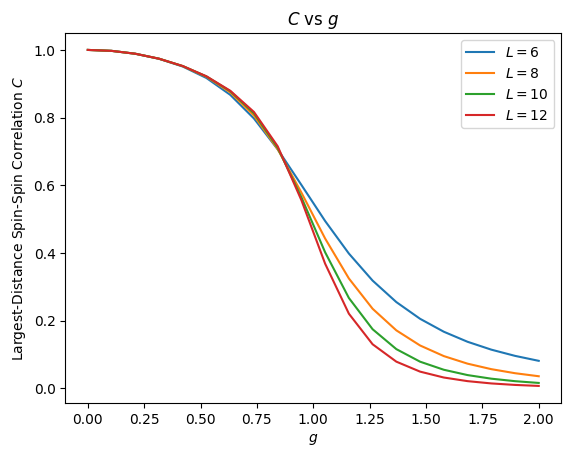

In [75]:
i = 0
for C_L in C:
    plt.plot(g_list, C_L, label="$L = " + str(L_list[i]) + "$")
    i += 1

plt.xlabel("$g$")
plt.ylabel("Largest-Distance Spin-Spin Correlation $C$")
plt.title("$C$ vs $g$")
plt.legend()
plt.show()

g).

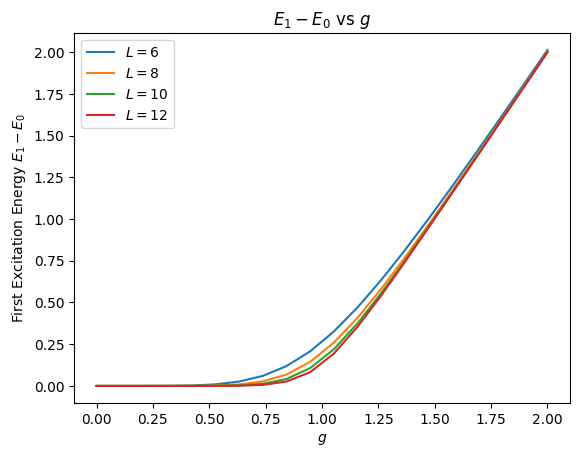

In [76]:
i = 0
for dE1_L in dE1_list:
    plt.plot(g_list, dE1_L, label="$L = " + str(L_list[i]) + "$")
    i += 1

plt.xlabel("$g$")
plt.ylabel("First Excitation Energy $E_1 - E_0$")
plt.title("$E_1 - E_0$ vs $g$")
plt.legend()
plt.show()

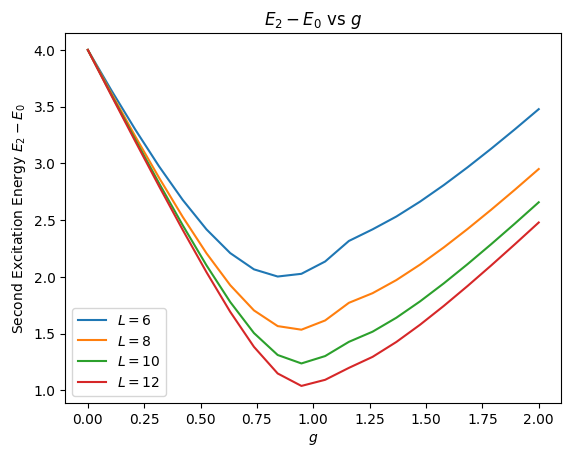

In [77]:
i = 0
for dE2_L in dE2_list:
    plt.plot(g_list, dE2_L, label="$L = " + str(L_list[i]) + "$")
    i += 1

plt.xlabel("$g$")
plt.ylabel("Second Excitation Energy $E_2 - E_0$")
plt.title("$E_2 - E_0$ vs $g$")
plt.legend()
plt.show()